# A simple Product Recommendation process basd on product descriptions

### Goal of the project

Given an amazon product description, I'm trying to see how what products will be 'recommended'. For example, if I'm purchasing a Banana Republic t-shirt, I want to see if the recommendation system just recommends other t-shirts or/and other Banana Republic products. For simplicity, I'll first visually inspect the results and then analyze results based on the descriptions.  The original metadata file had information on more than 1.5 million products. This json file has products from the "Clothing, Shoes and Jewelry" category. For this exercise, I'm using information from just 40000 products. 

### Motivation for this project

Any decent practical product recommender system will have been trained using a state-of-the-art deep learning architecture and with data from millios of products. What's more? Products evolve over time. Companies do away woth old products and try to promote new ones. This means they'll probably have to reinvent the wheel every now and then. They would have to obtain new reliable data, preprocess it and then train the model and evalute it's performance. 

But in this exercise, I'll try to obtain practical recommendations for products with absolutly no training at all. Sounds too good to be true? You're probably wondering where/how the magic happens. All I'm doing is transforming the descriptions of products using tf-idf vectorizer followed by computing their relative closeness (This step doesn't involve any modeling/using a complex deep learning architecture). 

But enough talk now. Let's get to business and see how this could work like a practical recommendation system!!!

<font color='maroon'>

### Outline of the entire process:

1) Read the preprocessed amazon products file.

2) Transform the descriptions in the file using tf-idf vectorization by ignoring all stop words.

3) Transform the tf-idf vector to a numpy array.

4) Compute the relative cosine similarities matrix for all the product descriptions.

5) Given a product, I'll try to find the nine closest products. This will be determined by the magnitude of the computed  relative cosine similarities.

6) Using the 'imUrl' field in the preprocessed metadata file, we'll plot each of the 9 relatd products that are recommended.
</font>

In [1]:
import pandas as pd
import json
import ast
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

### STEP 1

In [2]:
new_df = pd.read_csv('Clothing_file.csv')

In [3]:
#Inspecting the structure of the file
new_df.head()

Unnamed: 0                                              imUrl  \
0           0  http://ecx.images-amazon.com/images/I/41Nrta6E...   
1           1  http://ecx.images-amazon.com/images/I/419ED1sp...   
2           2  http://ecx.images-amazon.com/images/I/41qcR5%2...   
3           3  http://ecx.images-amazon.com/images/I/21hY4FKm...   
4           4  http://ecx.images-amazon.com/images/I/41IPc6iO...   

                                               title  \
0                Geneva Watch Face for Beading LWF26   
1     Iron Metal Dress Form Mannequin 29&quot; Brown   
2  Moneysworth and Best Shoe Care Neon Sport Lace...   
3    Operator Grade Field Jacket - Coyote Brown - XL   
4  Marquette University - Two-Toned Money Clip - ...   

                                         description  
0  Geneva watch face for beading.  This is a rect...  
1  Wrought Iron Metal Dress Form ~ Mannequin ~ Je...  
2  The colors are orange, lime and white. The col...  
3  The Operator Grade Field Jacket is soon to bec...  
4  Our Marquette University money clip is a hands...

In [4]:
len(new_df)

40333

We will now only choose the fields of interest

In [5]:
new_df = new_df[['imUrl', 'title', 'description']]

Dropping rows with NaN values

In [6]:
new_df = new_df.dropna()

The index will be reset by ignoring the old indices.

In [7]:
new_df = new_df.reset_index(drop = True)

In [8]:
len(new_df)

40333

### STEP 2

Now, the 'description' column will be transformed using the TF-IDF vectorizer and english stop words. (Common non-descriptive/non-adjective words 'a', 'and' and 'the' will be ignored. 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=2, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(new_df.description)

### STEP 3

In [10]:
Xtfidf = Xtfidf.toarray()

In [11]:
Xtfidf.shape

(40333, 25728)

In [12]:
Xtfidf[0]

array([0., 0., 0., ..., 0., 0., 0.])

### STEP 4

In this step, the relative cosine similarities matrix will be computed. For two duplicate images, the computed cosine similarity is 1. If the images are vastly different from one another, the similarity coefficient will be close to 0. Now, the cosine similarity matrix for just the first three images.

In [13]:
cos_matrix = cosine_similarity(Xtfidf[:3])

In [14]:
cos_matrix

array([[1.        , 0.        , 0.01927318],
       [0.        , 1.        , 0.0284615 ],
       [0.01927318, 0.0284615 , 1.        ]])

As expected, when a product correlation is computed with itself, 1 is the computed similarity. The first and third products are correlated too. But the magnitude is just ~0.02 which could indicate that they are entirely different products.

Since the relative similarity is computed for each element in the dataset, a square matrix is obtained.

Next, we'll compute the cosine similarities of all the products in our dataset.

In [13]:
words_siilar = cosine_similarity(Xtfidf)

In [14]:
words_siilar.shape

(40333, 40333)

We get a square matrix of size 40333x40333.

In the next cell bock, a simple function has been defined to help retrieve the image url and display the product image.

In [16]:
def get_images(url):          
    resp = urllib.request.urlopen(url)                        # This step read the image from the url
    image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #new_img = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
    return image

In [15]:
def get_related_products(index_num, data = new_df):
    j = 4 #This variable will be used in the subplots for positioning of the related product items
    similar_prod_arr = words_siilar[index_num].argsort()[::-1][:10] # Computes the 9 closes product descriptions based on cosin similarity matrix.
    prod_url = new_df['imUrl'].loc[index_num] # Obtaining the URL of the product image
    prod_img = get_images(prod_url) # Retrieving the image from the URL
    fig, ax = plt.subplots(figsize=(20,9))
    plt.subplot(4,3,2)
    plt.imshow(prod_img) # Plotting the product image
    plt.title('Product Image',fontsize=14, fontweight='bold')
    for i in similar_prod_arr[1:]:
        url = new_df['imUrl'].loc[i] # Retrieving the image URLs of all relatd products.
        img = get_images(url) # Retrieves the images of all items related to the product
        plt.subplot(4,3,j) 
        plt.imshow(img) # Plots the images
        j+=1

### STEP 6

Let's get started with the fun part already!

Before we begin seeing results right away, let us inspect th product in query.

In [17]:
new_df['description'].loc[24064]

'This The North Face Base Camp Luggage Tag is made from the same material The North Face uses for their mountaineering equipment. If it can go to the top of Everest, I am sure it will survive a ride on the airplane. These tags hold standard business cards and have a mesh window for easy visibility.'

What we have here is a Luggage Tag from the **The North Face** company. Let us inspect the recommended products and see if we get more luggage tags or other North Face products.

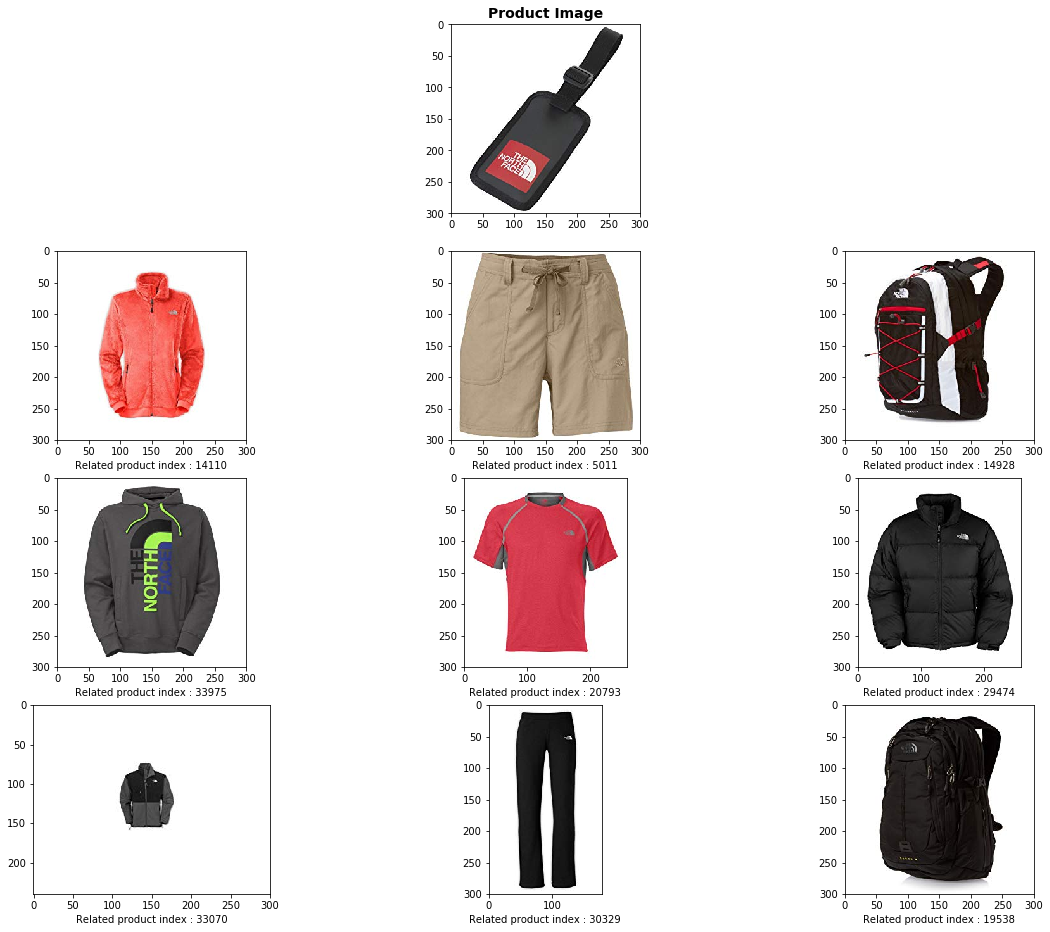

In [33]:
get_related_products(24064)

I've added code to record the index number of the product descriptions.

By just looking at the results, one may guess that these are other **North Face** products. Let's inspect some of the decriptions to be sure.

In [22]:
new_df['description'].loc[[14110, 30329, 19538, 29474]]

14110       The North Face Womens ModOsito Jacket
30329        The North Face Womens Half Dome Pant
19538    The North Face Surge Ii Charged Backpack
29474           The North Face Mens Nuptse Jacket
Name: description, dtype: object

And yes, we're being recommended other North Face products!

Let's move on to the next product

In [24]:
new_df['description'].loc[5102]

'Dallas Cowboys enameled pewter dangle NFL earrings.'

We have earrings from the **Dallas Cow Boys** franchise. Dallas Cowboys are an **NFL** team. Let's see if we get more products from the Cowboys or something else.

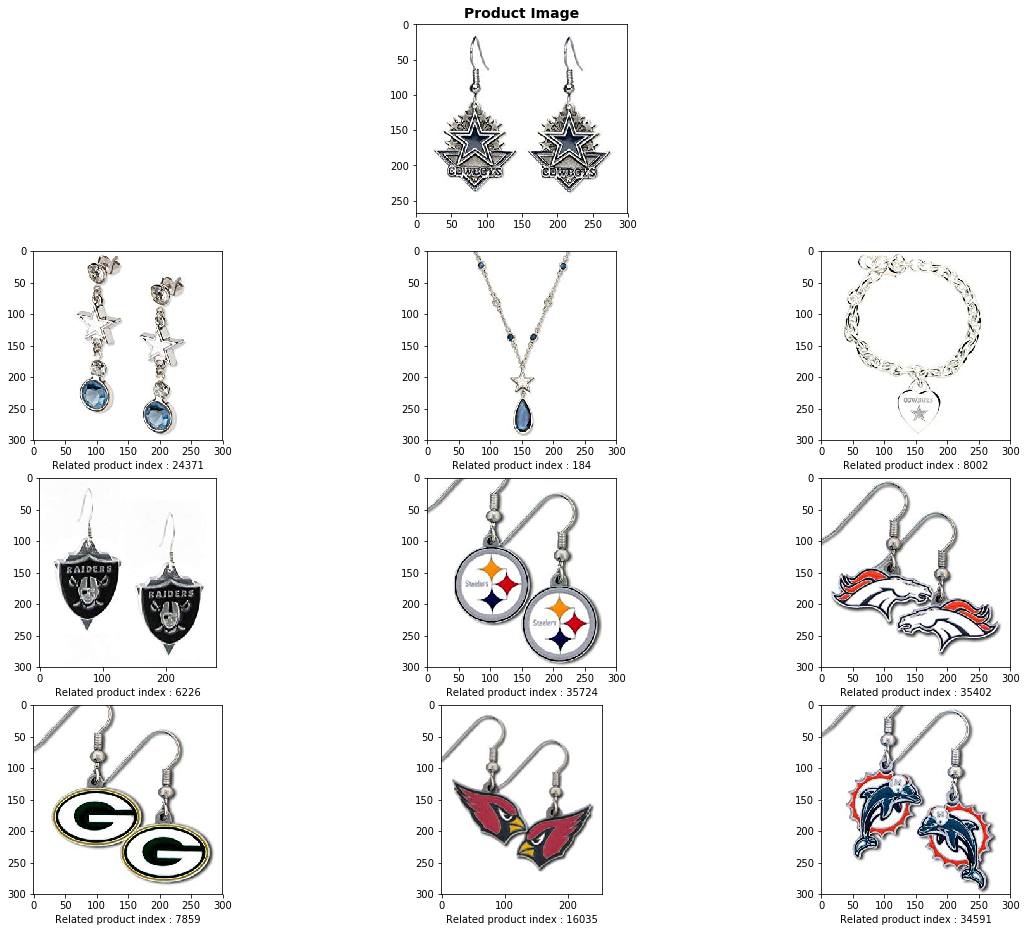

In [34]:
get_related_products(5102)

We seem to have gotten other earrings. Notice how the logo of the Dallas Cowboys is represented by a star. The first few recommendations seem to be of other Dallas Cow Boy earrings. Let's check out the other ones.

In [28]:
new_df['description'].loc[[6226, 35724, 35402, 7859, 16035, 34591]]

6226     Oakland Raiders enameled pewter dangle NFL ear...
35724                                 NFL  Dangle Earrings
35402                                 NFL  Dangle Earrings
7859                                  NFL  Dangle Earrings
16035                                 NFL  Dangle Earrings
34591                                 NFL  Dangle Earrings
Name: description, dtype: object

We got dangle earrings of **other NFL teams**. The earrings belong to Pittsbutgh Steelers, Greenbay packers, Miami Dolphins and others.

In [29]:
new_df['description'].loc[1787]

'Columbia offers a wide variety of outdoor performance footwear, outerwear, sportswear, and accessories. Columbia products are engineered using the best technologies and highest quality materials, providing you with innovative products that are functional yet stylish and a great value.'

This is a **footwear** product from **Columbia**. Let's see what the product recommendations are this time. Perhaps other footwear from Columbia?

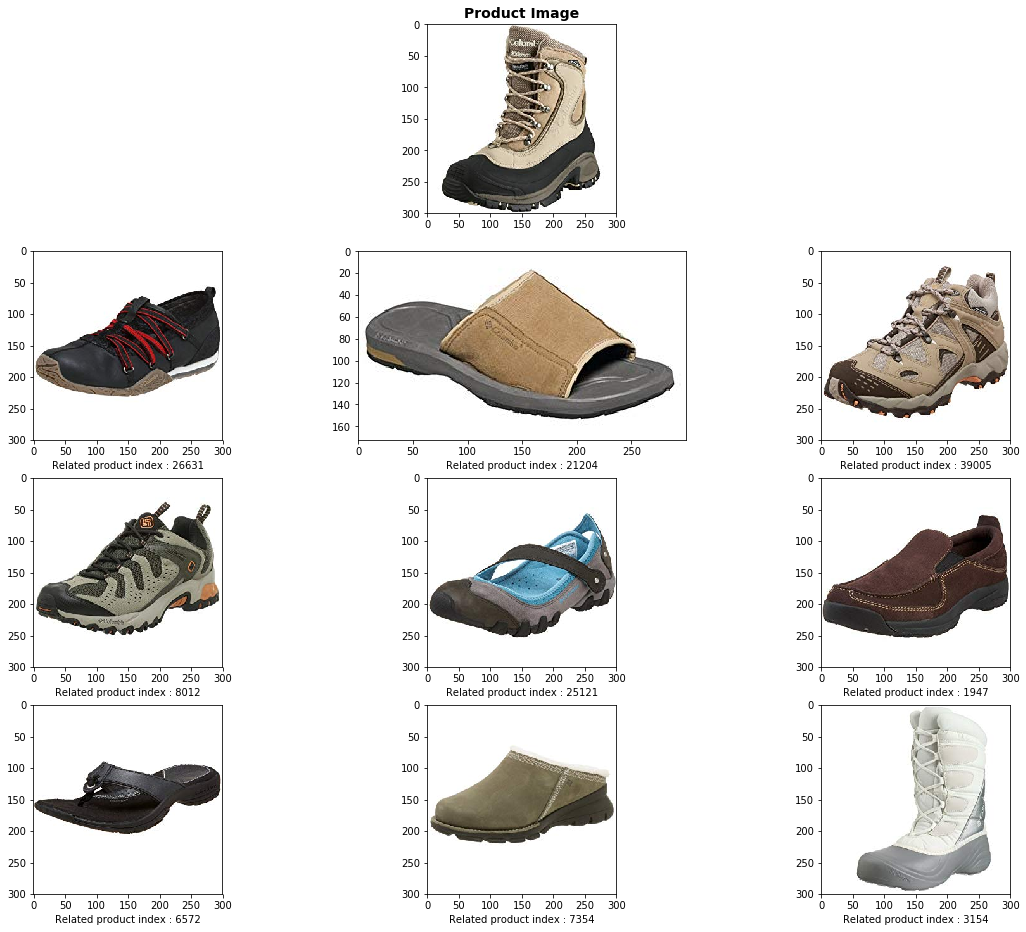

In [35]:
get_related_products(1787)

Another interesting result. Other types of footwear. But let's check out some of the recommended prodcuts' decriptions to see if they're from Columbia as well.

In [33]:
new_df['description'].loc[[26631, 8012, 7354, 1947, 3154]]

26631    Columbia offers a wide variety of outdoor perf...
8012     Columbia offers a wide variety of outdoor perf...
7354     Columbia offers a wide variety of outdoor perf...
1947     Columbia offers a wide variety of outdoor perf...
3154     Columbia offers a wide variety of outdoor perf...
Name: description, dtype: object

Interestingy, the product descriptions seem to be duplicates. Yet, we got different results. All of the, are from Columbia and outer footware.

In [60]:
new_df['description'].loc[32195]

"Whether you are Sith or Jedi, all of your Star Wars costuming needs are covered by Rubie's. Rubie's Costume Company has been bringing costumes and accessories to the world since 1950. As the world's leader we take seriously the mission to make dressing up fun. Mascots, rental quality costumes, masks, wigs, accessories, shoes and every significant licensed costume you want to wear can be found under the Rubie's brand. Still family owned, still family focused, Rubie's brings you fun for every season, Halloween, Christmas, Mardi Gras, Easter and all in-between."

We have a **Star Wars** costume from **Rubie**. Let's see what we get as recommendations.

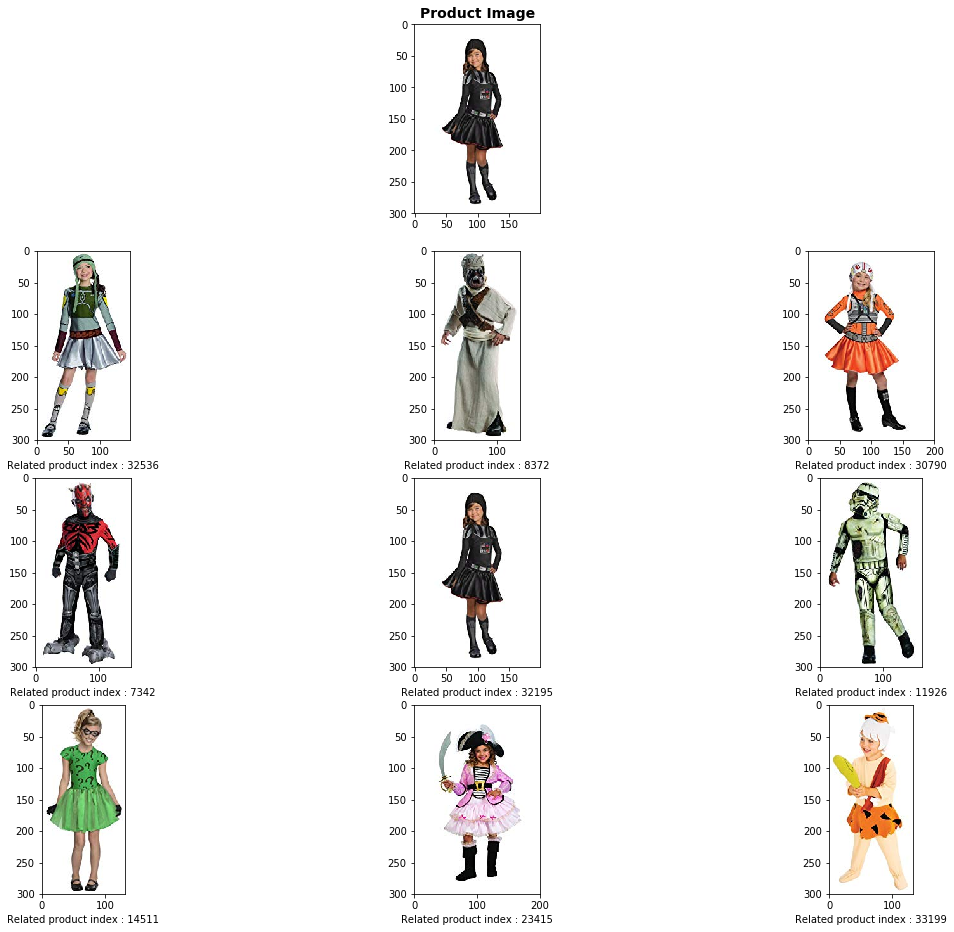

In [36]:
get_related_products(32195)

We get other mpvie themed costumes but only one of them seems to be from Star Wars. Let's see if the rest are from Rubie's.

In [62]:
new_df['description'].loc[[8372, 30790, 14511, 23415, 33199]]

8372     Whether you are Sith or Jedi, all of your Star...
30790    Whether you are Sith or Jedi, all of your Star...
14511    Rubie's Costume Company has been bringing cost...
23415    Rubie's Costume Company has been bringing cost...
33199    Rubie's Costume Company has been bringing cost...
Name: description, dtype: object

Cherry picking a few descriptions, they indeed seem to be from **Rubie's Costume Company**.

In [34]:
new_df['description'].loc[581]

"Join the dark side this Halloween with this collectible Supreme Edition Darth Vader mask. Darth Vader is the main antagonist from the famous Star Wars films. Known for his mastery of the force and intimidating black suit and helmet you'll have everything you need to make your Darth Vader costume complete."

We have a **Darth Vader** helmet. Darth Vade is a character in the **Star Wars** movies. Let's checkout the product recommendations. Probably more items related to Vader or other Star Wars products

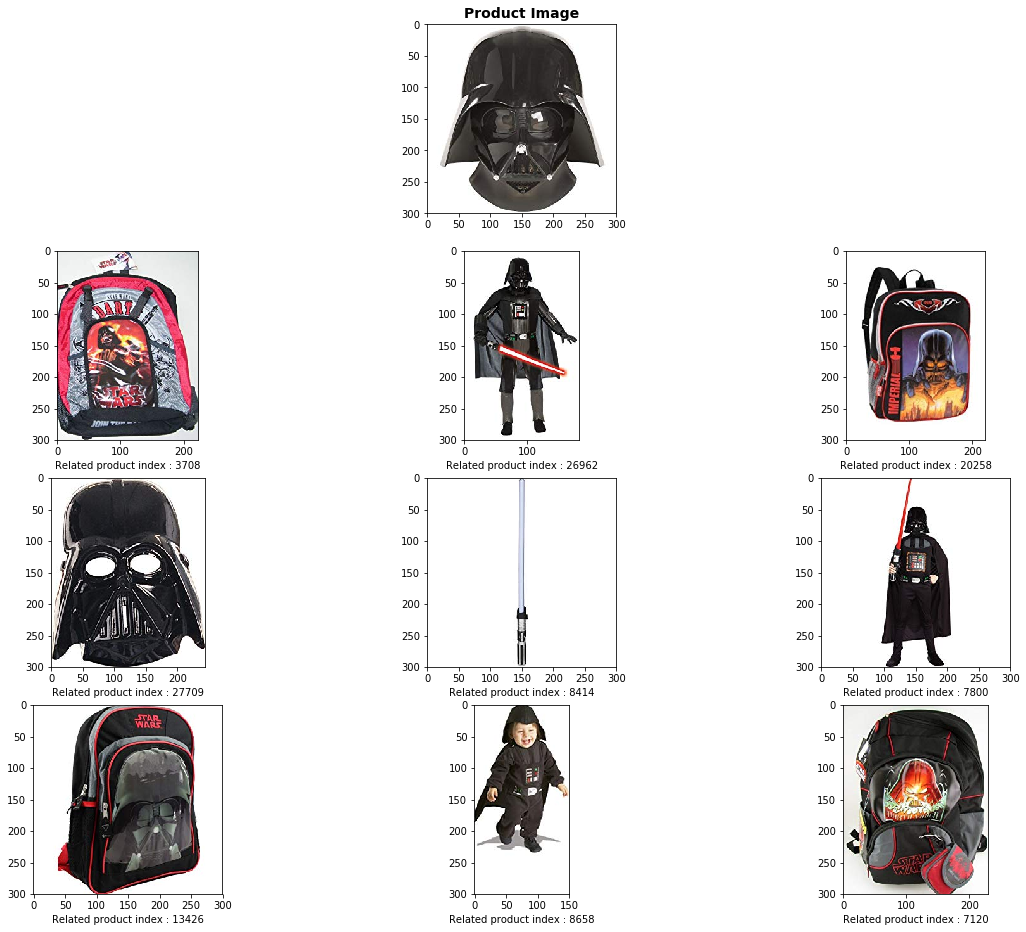

In [37]:
get_related_products(581)

As we can see, we get other Darth Vader themed product recommendations and more boradly, from the Star Wars franchise.

In [35]:
new_df['description'].loc[24784]

'Mini Backpack, Size: ~10" x 8" x 3"; Licensed Product'

We have a **Mini Backpack** or a kids backpack here. Let's check out the recommended items!

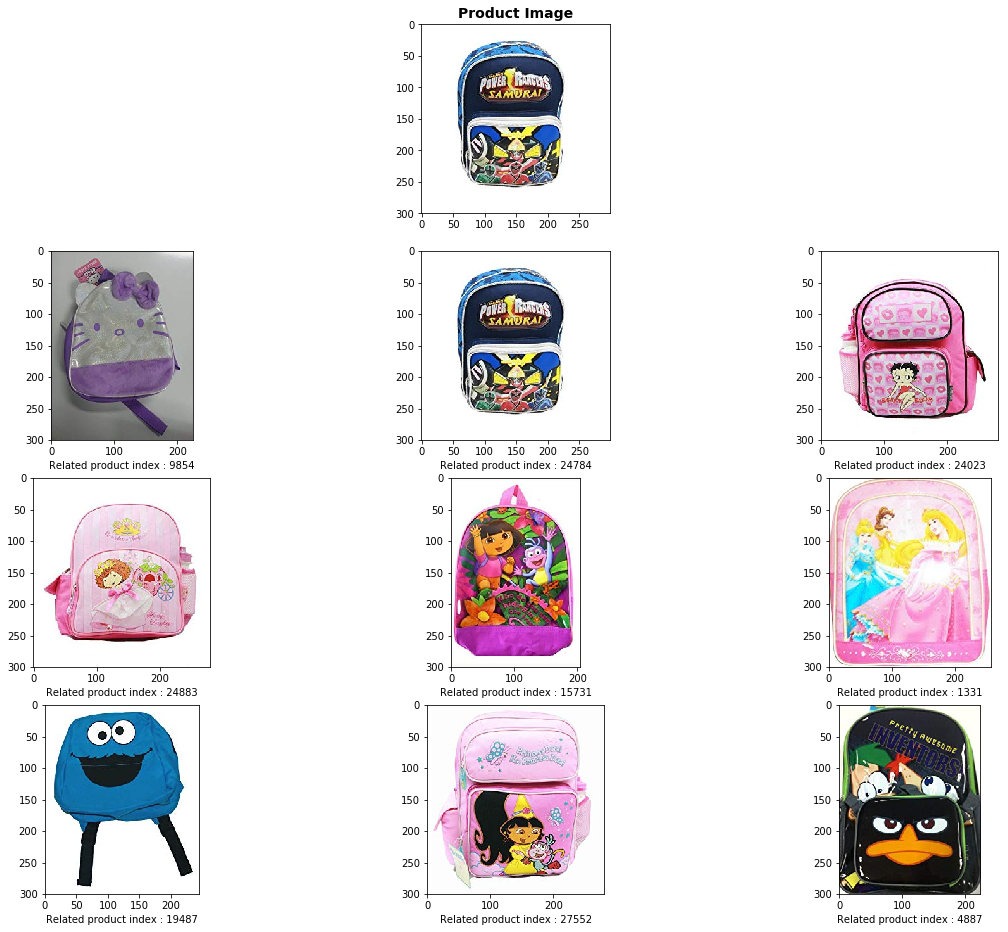

In [39]:
get_related_products(24784)

We get other kids' backpacks as recommendations. Seems like a pretty sensible recommendation, right? Now let's check out some of the product descriptions.

In [39]:
new_df['description'].loc[[9854, 19487, 1331]]

9854     Mini Backpack, Size: ~10" x 8" x 3"; Licensed ...
19487    * Zipper closure. * Mini backpack. * Officiall...
1331                                        Mini backpack.
Name: description, dtype: object

We see that words **Mini backpack** is in the descriptions of these items.

In [40]:
new_df['description'].loc[31556]

"Fabulous collection of official harry Potter enameled pins made for Harry Potter and the Philosopher's (Sorcerer's Stone) film release in 2001 by the renowned silversmiths of England, Arthur Price. There are 15 different designs, each one featuring a character or element from the original Harry Potter story.  No longer made and available in very limited quantities. Imported from England."

We have a Harry Potter product here. More merchanise from the wizarding world perhaps? Let's find out!

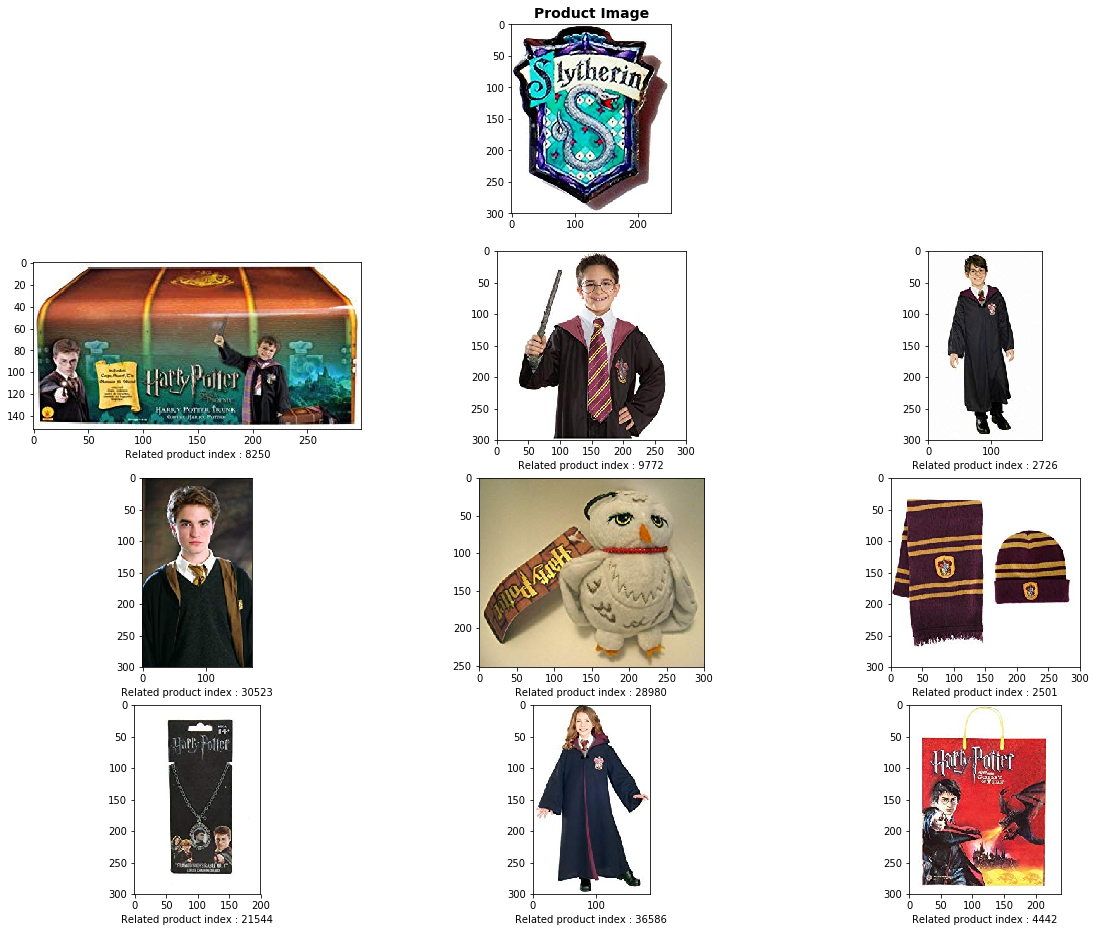

In [40]:
get_related_products(31556)

And that wasn't even hard to call! We do get recommendations of ther Harry Potter merchandize.

In [41]:
new_df['description'].loc[5248]

'Believe it! After 86 years, The Curse is finally broken and the Boston Red Sox are World Champs for the first time since 1918! Celebrate in style with your championship team! This comfortable cotton garment washed cap is a great way to announce the Boston Red Sox 2004 World Series Champions status.'

We have a **cap**. Not just any cap but a **Boston Red Sox** cap. They're a popular baseball team.

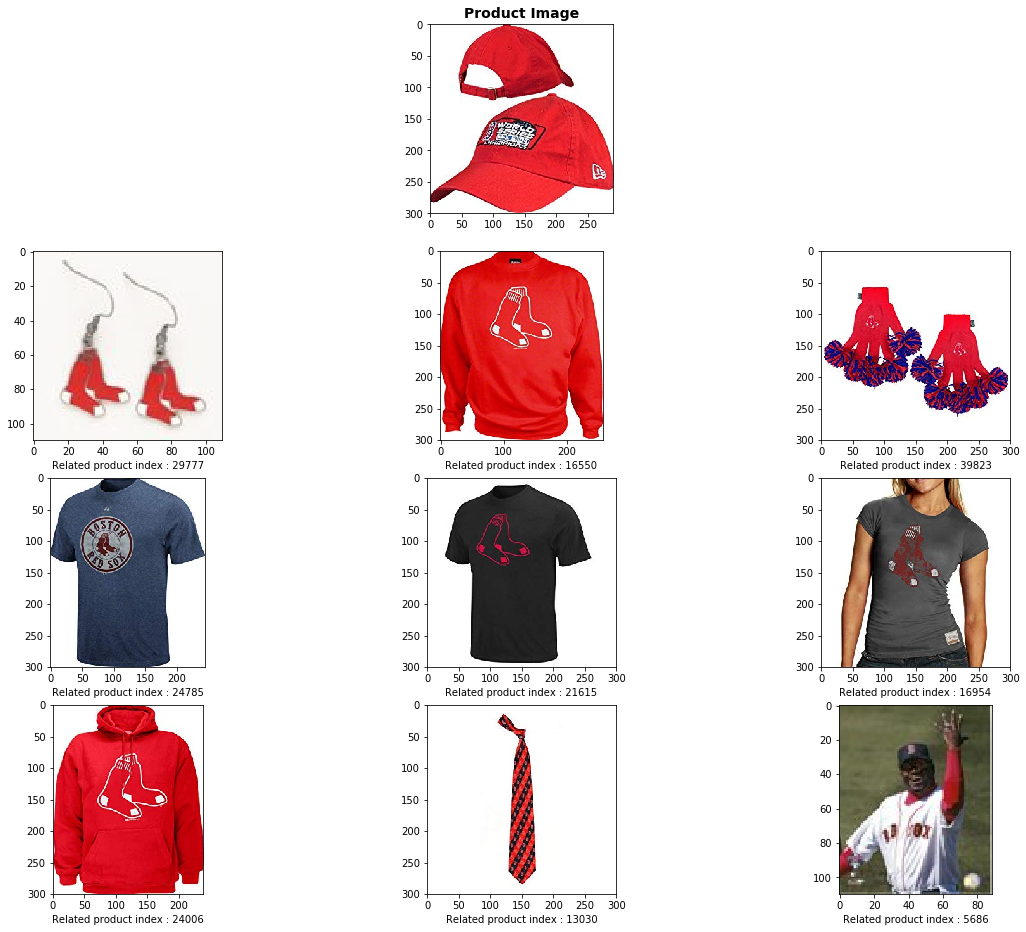

In [41]:
get_related_products(5248)

We get other recommendations from merchandize of Boston Red Sox!

In [42]:
new_df['description'].loc[14124]

'Angry Birds Baseball Cap Kids Size Hat Adjustable Velcro Closure on Back 1 Size Fits Most Kids (Head Girth Max Approximately 21 Inches)'

We have a **baseball cap** from **Angry Birds**

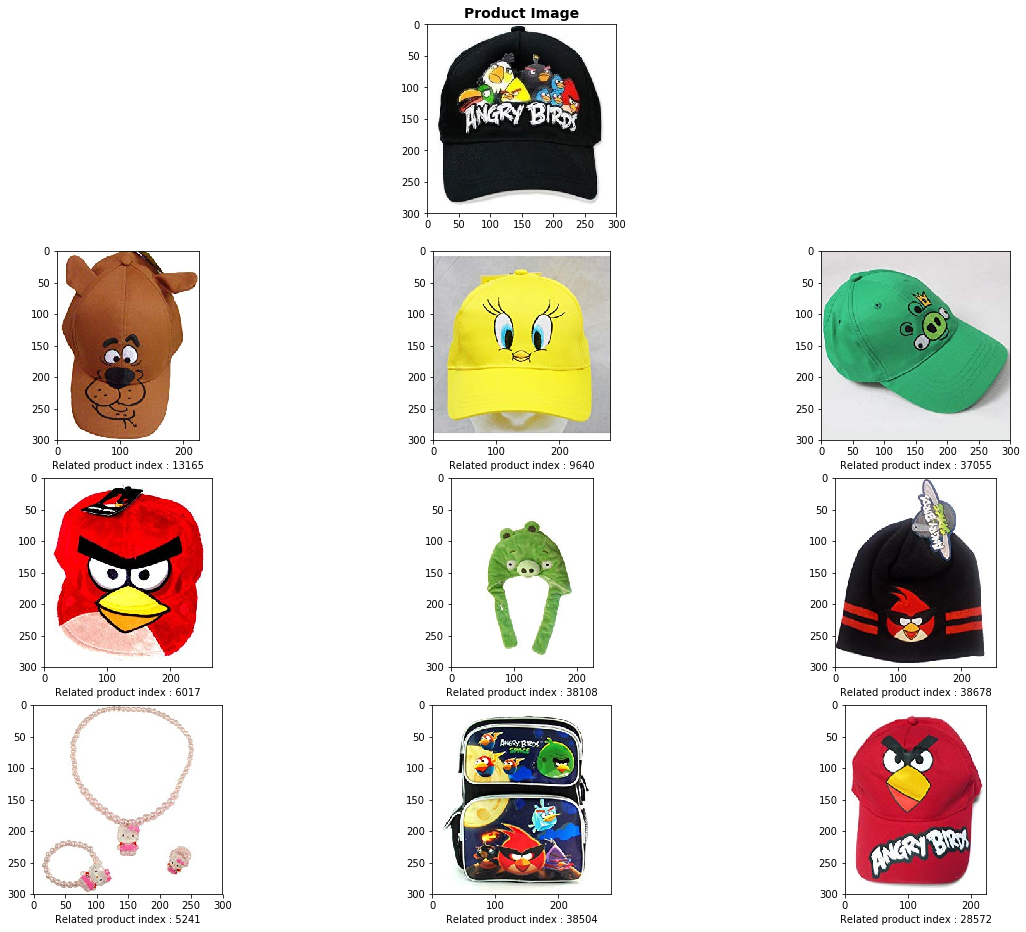

In [43]:
get_related_products(14124)

And we get other products from the **Angry Birds** merchandize.

In [45]:
new_df['description'].loc[12230]

"This New England Patriots -White- Women's Dazzle Trim Hooded Sweatshirt from Reebok has all the added detail you want to show your fanhood off in fashionable style. Features tackle twill applique wordmark with contrast color embroidery on chest and screen print team logo and Rbk logo on left sleeve."

We have a **hooded sweatshirt** from **New England Patriots**.

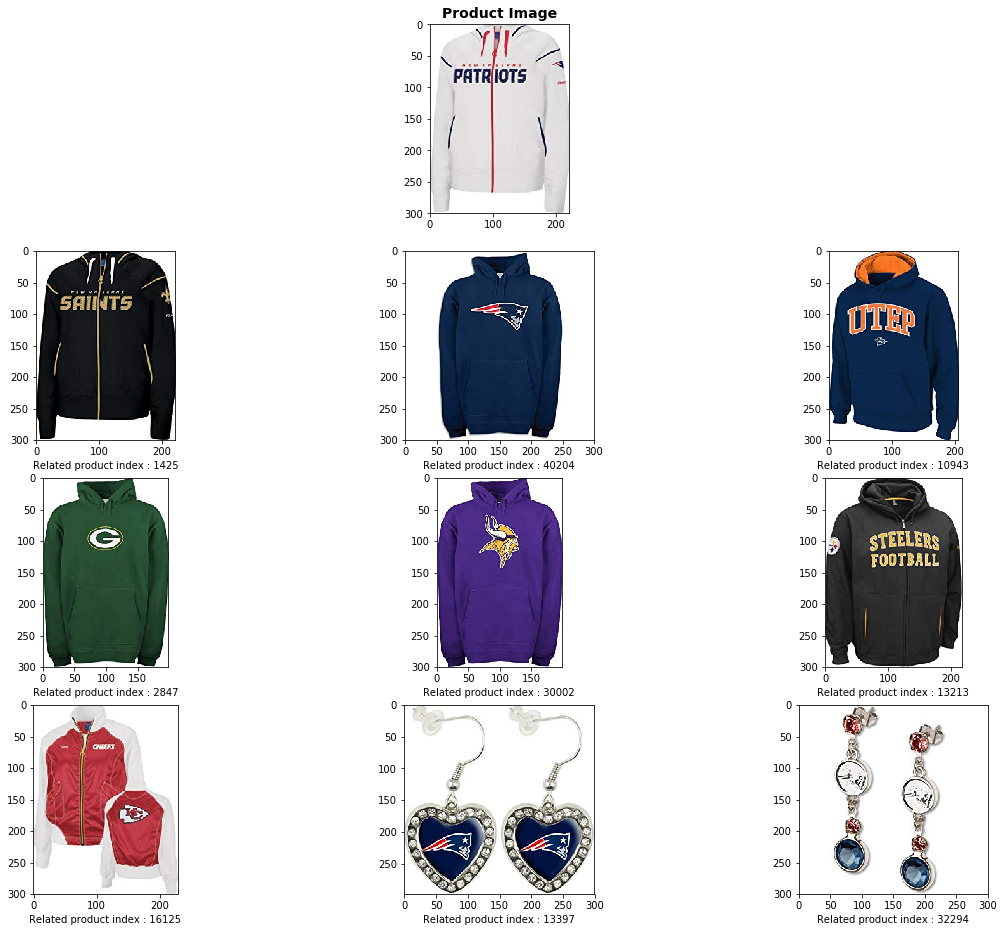

In [44]:
get_related_products(12230)

This time, we get other hooded sweatshirts but from other **NFL** franchises. The last two results are earring from the same company. The other sweatshirts are from Kansas Chiefs, Denver Broncos, Steelers and others.

In [47]:
new_df['description'].loc[4667]

'Disney Princess Watch (assorted colors)Lovely and vibrant Disney Princess watch with all your favorite characters!Not water-resistantPerfect for any fan!'

We have a **Disney Princess** themed **watch**. More Disney themed products or other watches?

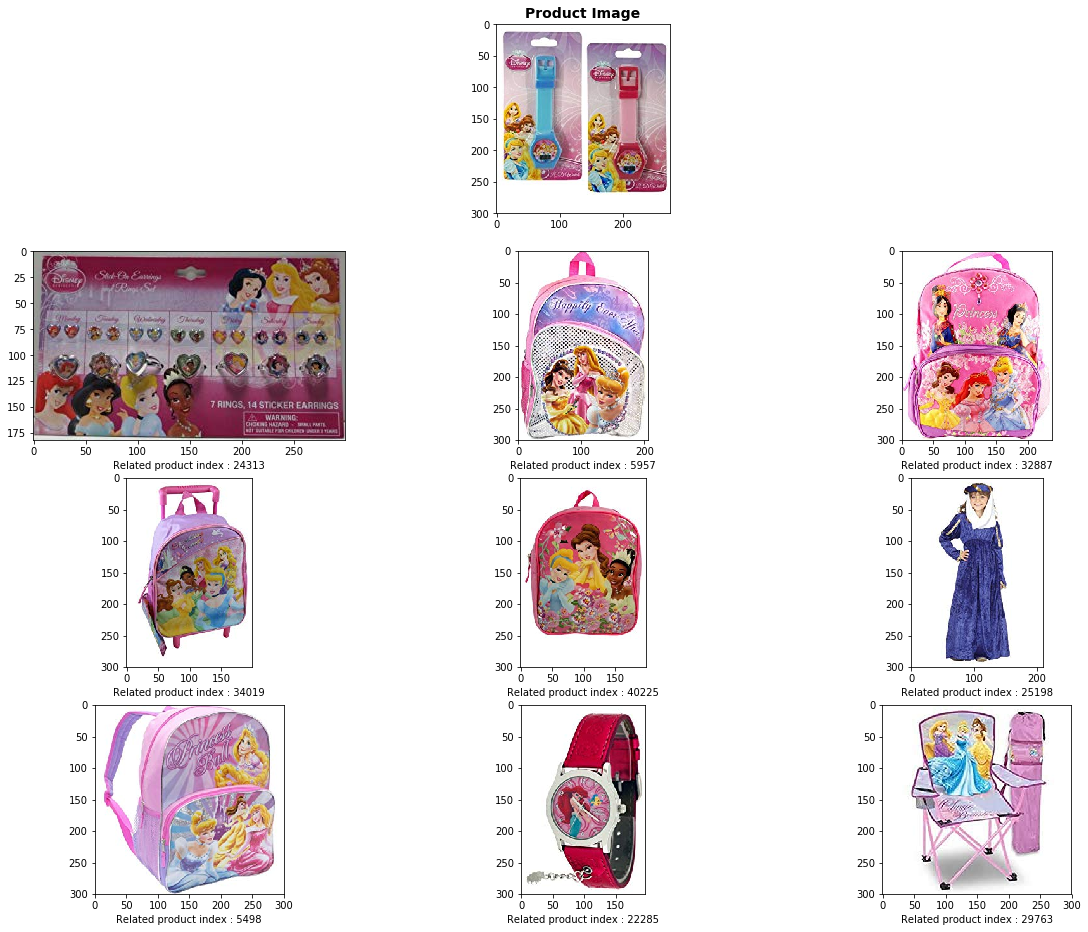

In [45]:
get_related_products(4667)

We have another great result. We get other **Disney princess** themed product recommendations.

In [48]:
new_df['description'].loc[32353]

"Saban's power ranger samurai"

We have am action figure from the **Power Rangers**

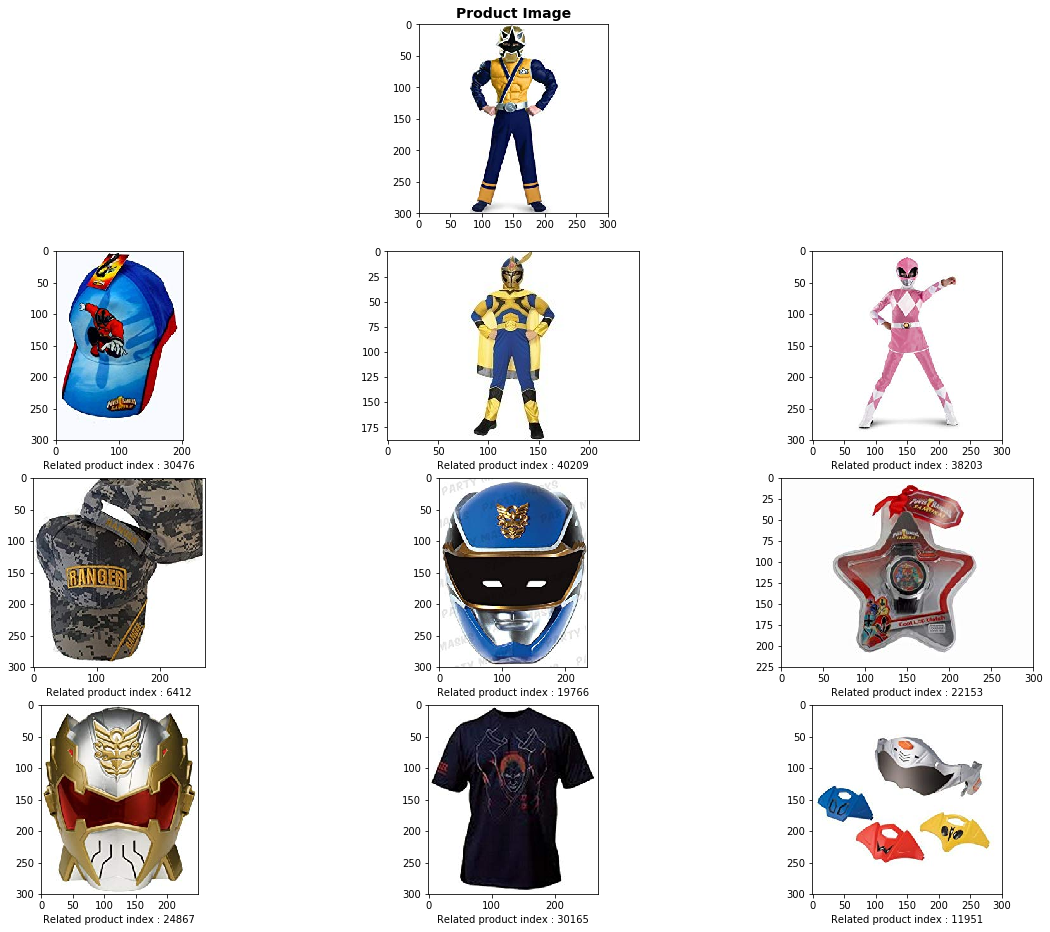

In [46]:
get_related_products(32353)

We get other Power Ranger themed products as recommendations. Let's check out the 4th and 8th recommendations as they seem different.

In [49]:
new_df['description'].loc[[6412, 30165]]

6412                      Ranger Embroidered Hat
30165    Cold Steel TH1 Samurai Tee Shirt Medium
Name: description, dtype: object

We have a "ranger" hat and a "Samurai" tee shirt which are key words from the main product's description and hence the results!